# Examining Racial Discrimination in the US Job Market

### Background
Racial discrimination continues to be pervasive in cultures throughout the world. Researchers examined the level of racial discrimination in the United States labor market by randomly assigning identical résumés to black-sounding or white-sounding names and observing the impact on requests for interviews from employers.

### Data
In the dataset provided, each row represents a resume. The 'race' column has two values, 'b' and 'w', indicating black-sounding and white-sounding. The column 'call' has two values, 1 and 0, indicating whether the resume received a call from employers or not.

Note that the 'b' and 'w' values in race are assigned randomly to the resumes when presented to the employer.

<div class="span5 alert alert-info">
### Exercises
You will perform a statistical analysis to establish whether race has a significant impact on the rate of callbacks for resumes.

Answer the following questions **in this notebook below and submit to your Github account**. 

   1. What test is appropriate for this problem? Does CLT apply?
   2. What are the null and alternate hypotheses?
   3. Compute margin of error, confidence interval, and p-value. Try using both the bootstrapping and the frequentist statistical approaches.
   4. Write a story describing the statistical significance in the context or the original problem.
   5. Does your analysis mean that race/name is the most important factor in callback success? Why or why not? If not, how would you amend your analysis?

You can include written notes in notebook cells using Markdown: 
   - In the control panel at the top, choose Cell > Cell Type > Markdown
   - Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet


#### Resources
+ Experiment information and data source: http://www.povertyactionlab.org/evaluation/discrimination-job-market-united-states
+ Scipy statistical methods: http://docs.scipy.org/doc/scipy/reference/stats.html 
+ Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet
+ Formulas for the Bernoulli distribution: https://en.wikipedia.org/wiki/Bernoulli_distribution
</div>
****

In [84]:
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np
from scipy import stats

In [2]:
data = pd.io.stata.read_stata('data/us_job_market_discrimination.dta')

In [3]:
# number of callbacks for black-sounding names
sum(data[data.race=='w'].call)

235.0

In [4]:
data.head()

,id,ad,education,ofjobs,yearsexp,honors,volunteer,military,empholes,occupspecific,...,compreq,orgreq,manuf,transcom,bankreal,trade,busservice,othservice,missind,ownership
0,b,1,4,2,6,0,0,0,1,17,...,1,0,1,0,0,0,0,0,0,
1,b,1,3,3,6,0,1,1,0,316,...,1,0,1,0,0,0,0,0,0,
2,b,1,4,1,6,0,0,0,0,19,...,1,0,1,0,0,0,0,0,0,
3,b,1,3,4,6,0,1,0,1,313,...,1,0,1,0,0,0,0,0,0,
4,b,1,3,3,22,0,0,0,0,313,...,1,1,0,0,0,0,0,1,0,Nonprofit


<div class="span5 alert alert-success">
<p>Your answers to Q1 and Q2 here</p>
</div>

For Q1, z-statistic can be used because I am comparing two porpotions. CLT is aplicable since I still can use w and b as two sample distributions.

For Q2, p1 is the propotion of black-sounding names applicants who receieve call backs and p2 is the propotion of white-sounding names applicants who receieve call backs
* Null hypothesis is that applicants with black-sounding names receieve similar amount of calls to applicants with white-sounding names (Ho: p1 - p2 = 0)
* Alternative hypothesis is that applicants with black-sounding names receieve different amount of calls from applicants with white-sounding names (Ha: p1 - p2 ≠ 0)

In [25]:
w = data[data.race=='w']
b = data[data.race=='b']

In [27]:
# Your solution to Q3 here

## without bootstrapping
* Before perform any siginificance test, I want to check the conditions: random, independence, and normal distribution. 
    * The random condition is fulfilled based on the description ("Note that the 'b' and 'w' values in race are assigned randomly to the resumes when presented to the employer."). 
    * The independence is fulfilled. n=2435 is 10% lower than the whole population.
    * The normal distribution is fulfilled. n=2435 is more than 30

* Result: The z score of propotion difference between w and b is 4.1155 and the p value from the z table is < 0.0001. With the conditions are achieved, it indicates that the null is rejected. Alternative hypothesis is established. The applicants with black-sounding names receieve different amount of calls from applicants with white-sounding names.

In [28]:
# Check how many data points first
print len(w), len(b)

2435 2435


In [99]:
# Propotion of calls in w group and b group
w_call = len(w[w['call'] == 1]) / 2435.0
b_call = len(b[b['call'] == 1]) / 2435.0
print w_call, b_call

0.0965092402464 0.064476386037


In [93]:
# variance of w and b
var_w = (w_call * (1-w_call)) / len(w)
var_b = (b_call * (1-b_call)) / len(b)

In [97]:
# the difference betwen w and b in propotion and standard deviation
wb_dif = w_call -b_call
wb_dif_sd = np.sqrt(var_w + var_b)

In [98]:
# In terms of 95% confidence interval, critical z is 1.96 from z table
z_critical = 1.96

In [123]:
# Here we can calculate margin of error and confidence interval of the propotion difference 
margin_error = z_critical * wb_dif_sd
print 'Margin of error: ' + str(margin_error)
print 'Confidence interval: ' + str(wb_dif - margin_error) + ', ' + str(wb_dif + margin_error) 

Margin of error: 0.0152554063499
Confidence interval: 0.0167774478596, 0.0472882605593


In [124]:
wb_dif_z = wb_dif / wb_dif_sd
wb_dif_z

4.1155504357300003

## with bootstrapping
* Result: With bootstrapping, I can simulate the data 10000 times. After simulation, I calculate porpotion difference and its 95% confidence interval. They both are similar to the result without bootstrapping. Based on null hypothesis p1 = p2, I calculate the distribution of porption difference with bootstrapping. I further use histogram to visualize the bootstrapping distribution and porpotion difference of samples (red line). Now, I can get p-value: 0.0001 which is lower than alpha. The null hypothesis is rejected.

In [67]:
def propotion(data):
    propotion = np.sum(data) / len(data)
    return propotion

In [71]:
# Randomly select and replace bootstrapping samples
def bootstrap_replicate_propotion(df, func):
    array = df['call'].values
    return func(np.random.choice(array, size=len(df)))

In [79]:
# Bootstrapping replicates: repeat the process (size) and calculate porpotion of bootsrapping sample in every repeat
def draw_bs_reps_propotion(df, func, size):
    """Draw bootstrap replicates."""
    
    # Initialize array of replicates: bs_replicates
    bs_replicates = np.empty(size)

    # Generate replicates
    for i in range(size):
        bs_replicates[i] = bootstrap_replicate_propotion(df, func)

    return bs_replicates

In [126]:
# The difference of bootstrapping replicates of w and b
wb_dif_bs = draw_bs_reps_propotion(w, propotion, 10000) - draw_bs_reps_propotion(b, propotion, 10000)
print 'Bootstrapping replicates: ' +  str(wb_dif_bs)

bootstrapping replicates: [ 0.01806982  0.04640657  0.03080082 ...,  0.03244353  0.02833676
  0.03162218]


In [129]:
wb_dif_bs_95CI = np.percentile(wb_dif_bs, [2.5, 97.5])
print '95% confidence interval with bootstrapping: ' + str(wb_dif_bs_95CI)

95% confidence interval with bootstrapping: [ 0.0164271   0.04722793]


In [118]:
# If null is true, b = w in propotion of calls receieved 
wb_dif_bs_null = draw_bs_reps_propotion(w, propotion, 10000) - draw_bs_reps_propotion(w, propotion, 10000)

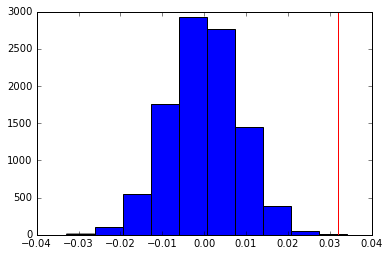

In [119]:
# Visualize null hypothesis's distribution and porpotion difference of samples 
plt.hist(wb_dif_bs_null)
plt.axvline(wb_dif, color='r')

In [121]:
wb_dif_bs_null_pvalue = np.sum(wb_dif_bs_null >= wb_dif) / float(len(wb_dif_bs_null))
wb_dif_bs_null_pvalue

0.0001

<div class="span5 alert alert-success">
<p> Your answers to Q4 and Q5 here </p>
</div>

Answer for Q4: 

The callback porpotion of apllicants with white-sounding names is higher than the call-back porpotion of applicants with black-sounding names by ~3%. I want to know whetehr the difference is statistically significant. In bootstrapping methods, I repeat this data 10000 times by simulation. The result indicates that the null hypothesis is rejected and the porpotion difference between apllicants with white-sounding names and apllicants with black-sounding names is statistically significant. 

Answer for Q5: 

I would not say race/name is the mostimportant factor in callback success yet since there are many other features in this data. However, it can be one of the most important factors affecting successful callback rate. Mutiple linear regression can be used to estimate which features are import for callback success. Scikit-learn Python library provides two ways (Recursive Feature Elimination and feature importance) to identify important factors for predicting the response variable (callbakc success here). 